# 5. Preprocessing and Modelling

#### Importing Necessary Libraries

In [22]:
# For data manipulation 
import pandas as pd
# For data analysis
import numpy as np
#For data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Warning libraries
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')

# Modelling libraries
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm#a library to help with auto_arima
import itertools

# Metrics Libraries
from sklearn.metrics import mean_absolute_percentage_error


In [6]:
#Loading the cleaned data

new_data = pd.read_csv('new_df.csv')

In [7]:
new_data.head()

,Date,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,22yr_ROI,22yr_CV,5yr_ROI,5yr_CV,value
0,1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,2.083782,0.256487,0.260827,0.066302,334200.0
1,1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,0.365295,0.152680,0.533842,0.124597,235700.0
2,1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,0.567966,0.143950,0.283158,0.072385,210400.0
3,1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1.623971,0.237364,0.258788,0.056243,498100.0
4,1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,0.571798,0.178326,0.070485,0.023086,77300.0


In [8]:
new_data['Date'] = pd.to_datetime(new_data.Date)
new_data.set_index('Date',inplace = True)

## 5.1 Preprocessing

In this phase we will transform the raw data into a form that will make it suitable for building and training our model.

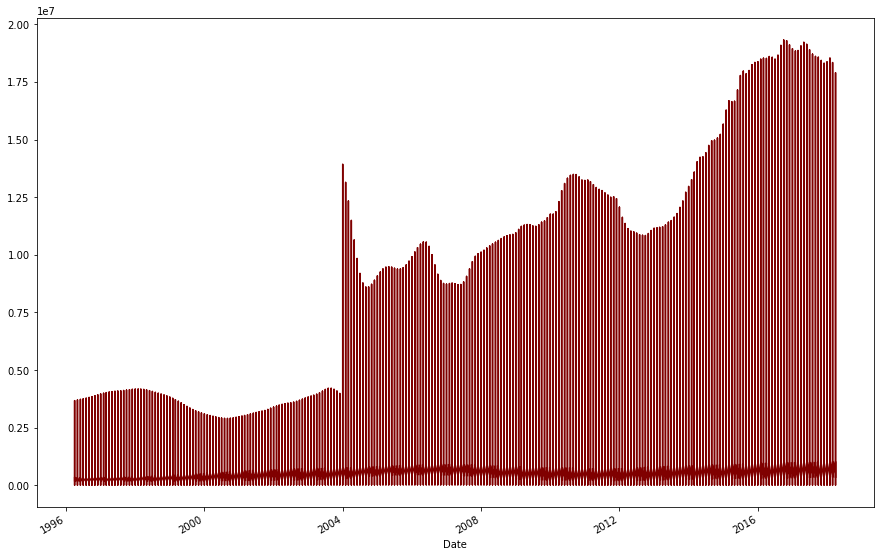

In [9]:
# Visualizing our data

new_data.value.plot(figsize=(15,10),color = 'maroon');

From the graph, there seems to be an increasing trend in data. However,let's reconfirm this using both rolling statistics and the Dickey-Fuller test.

#### Stationarity Test

In [10]:
# create a stationarity function 
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=6, center=False).mean()
    roll_std = TS.rolling(window=6, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

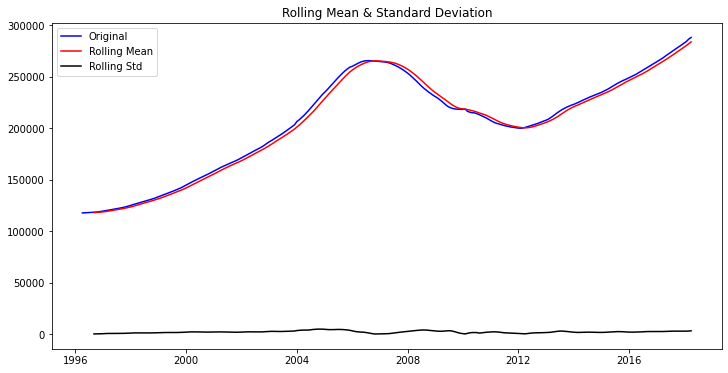

Results of Dickey-Fuller Test: 

Test Statistic                  -1.914667
p-value                          0.325193
#Lags Used                       2.000000
Number of Observations Used    262.000000
Critical Value (1%)             -3.455558
Critical Value (5%)             -2.872636
Critical Value (10%)            -2.572683
dtype: float64


In [11]:
# Grouping our data into months

monthly_data = new_data.resample('MS').mean()['value']

# Checking the stationarity of our series

stationarity_check(monthly_data)

Though the variation in standard deviation is small, the mean is increasing with time and thus, this is not a stationary series.The pvalue is greater than 0.05 hence we fail to reject the null hypothesis that the series is non-stationary. All the tests show that our series is not stationary.

#### Time Series Decomposition

Now that we know that our data is not stationary,we will allso investigate its pattern in the past which will come in handy when forecasting future house values. We break it into three components to better see its trend, seasonality and residuals.

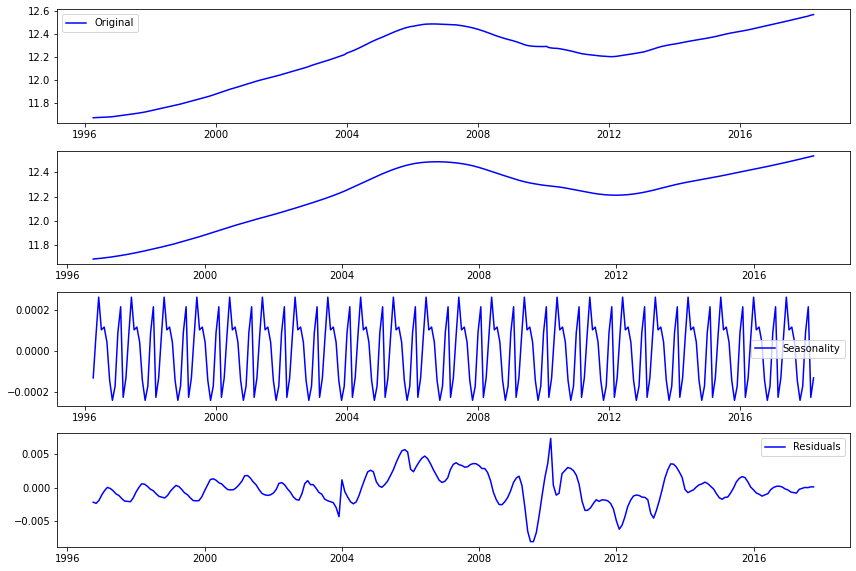

In [12]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(monthly_data))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(monthly_data), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

This makes it easier to identify a changing mean or variation in our data. From the decomposition plot it clearly shows an upward trend in our series with seasonality and minimal variation.We will need to detrend our data because if seasonality and trend are part of the time series then there will be effects in the forecast value. As the pattern of the forecasted time series can be different from the older time series.

#### Detrending the Series
We decided to use differencing as a method of detrending the data because differencing is similar to the derivative of a function and more powerful than the adjustment through regression and seasonal means

In [13]:
# Differencing to remove trends

data_diff = monthly_data.diff(periods=24).dropna()
data_diff.head(5)


Date
1998-04-01     9394.335394
1998-05-01     9917.679821
1998-06-01    10441.734022
1998-07-01    10964.776201
1998-08-01    11481.274197
Freq: MS, Name: value, dtype: float64

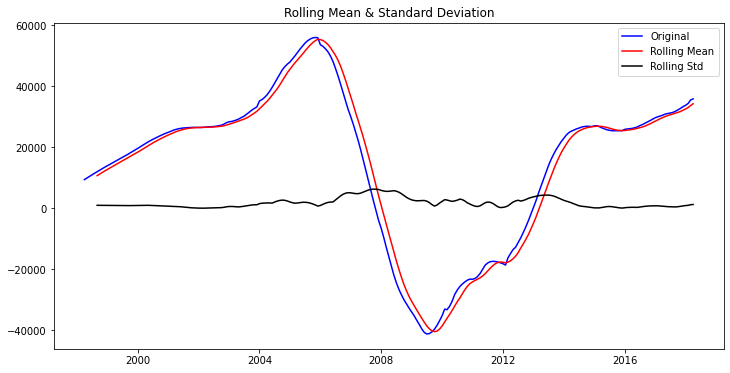

Results of Dickey-Fuller Test: 

Test Statistic                  -3.109067
p-value                          0.025889
#Lags Used                       2.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


In [14]:
# Rechecking stationarity

stationarity_check(data_diff)

The p-value is now below 0.05 therefore we reject the null hypothesis that the series is non-stationary.

#### Auto-Correlation and Partial Auto-Correlation of the Differenced Data

Plotting the ACF and PACF functions help determine the AR and MA components in the models we intend to build. These functions consider all the above components of a time series like the trend and the seasonality and find their correlations

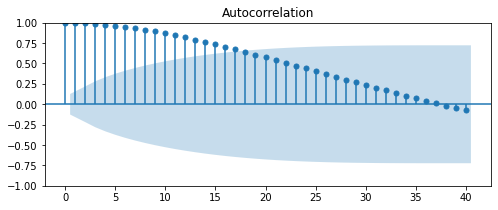

In [15]:
# Plot the ACF

from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(data_diff,ax=ax, lags= 40);

From the above lags between 1 and 17 are in the statistically significant region meaning time periods within that span can affect present values.

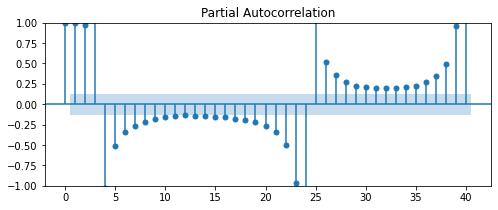

In [16]:
# Plot the PACF

from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(data_diff,ax=ax, lags=40);

From the PACF, lags with high correlation and that are within the statistically significant region, are between lags 1 and 4. 

## 5.2 Time Series Modelling

The AIC(Akaike's Information Criterion) and BIC(Bayesian Information Criterion) will be determinants of the the model perfomances. 

AIC is a metric that helps in the evaluation of a model that takes the results of the maximum likelihood as well as the total number of parameters. The lower the AIC the better the model performance. 

The BIC is similar to AIC but differs in that it considers the number of rows in the dataset. The lower the BIC the better the model performance.

#### Baseline Model (MA Model)

We will construct an MA model as our baseline model then increase its complexity with more complex models.

In [17]:
# Fit an ARMA model
mod_ma = ARIMA(data_diff, order=(0,0,1))
res_ma = mod_ma.fit()

# Print out summary information on the fit
print(res_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  241
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2620.418
Date:                Wed, 30 Nov 2022   AIC                           5246.837
Time:                        11:44:56   BIC                           5257.291
Sample:                    04-01-1998   HQIC                          5251.049
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.484e+04   2058.583      7.210      0.000    1.08e+04    1.89e+04
ma.L1          1.0000      0.132      7.562      0.000       0.741       1.259
sigma2      1.652e+08    8.9e-07   1.86e+14      0.0

The huge nature of the cofficients are evident that our model is very unsafisfactory.This model has a high AIC of 5246.837 that justfies its unsatisfactory nature. Also, the BIC is large 5257.291 that affirms this conclusion.

#### AR Model

In [18]:
# Fit an AR model
mod_ar = ARIMA(data_diff, order=(1,0,0))
res_ar = mod_ar.fit()

# Print out summary information on the fit
print(res_ar.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  241
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2073.427
Date:                Wed, 30 Nov 2022   AIC                           4152.854
Time:                        11:44:56   BIC                           4163.308
Sample:                    04-01-1998   HQIC                          4157.065
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.484e+04   3.22e+04      0.461      0.645   -4.82e+04    7.79e+04
ar.L1          0.9977      0.003    368.889      0.000       0.992       1.003
sigma2      1.704e+06   4073.497    418.312      0.0

This second model is an improvement of the first model. It has lower AIC and BIC values that stands at 4152.854, and 4163.308 respectively.

#### ARMA Model

In [19]:
# Fit an ARMA model
mod_arma = ARIMA(data_diff, order=(1,0,1))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  241
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1966.920
Date:                Wed, 30 Nov 2022   AIC                           3941.840
Time:                        11:44:56   BIC                           3955.780
Sample:                    04-01-1998   HQIC                          3947.456
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.484e+04    3.4e+04      0.436      0.663   -5.18e+04    8.15e+04
ar.L1          0.9973      0.003    324.030      0.000       0.991       1.003
ma.L1          0.7497      0.038     19.600      0.0

The third model is an improvement of the first and second model. It has lower AIC and BIC values that stands at 3941.840, and 3955.780 respectively.

#### ARIMA Model

In [37]:
# Fit an ARIMA model

mod_arima = ARIMA(data_diff, order=(1,1,1))
res_arima = mod_arima.fit()

# Print out summary information on the fit
print(res_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  241
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1786.068
Date:                Wed, 30 Nov 2022   AIC                           3578.136
Time:                        12:47:14   BIC                           3588.578
Sample:                    04-01-1998   HQIC                          3582.343
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9388      0.010     98.014      0.000       0.920       0.958
ma.L1         -0.2384      0.042     -5.641      0.000      -0.321      -0.156
sigma2      1.487e+05   4248.324     34.996      0.0

Fantastic! Our AIC and BIC keep getting lower which means our model is performing better.

#### SARIMA Model

SARIMA is the ideal model to apply since it takes seasonality into account.

In [23]:
#using auto_arima- it does a random search for the best pdq,PDQS  
sarima_model = pm.auto_arima(monthly_data, 
                             m=12,
                             seasonal=True,
                             start_p=0,
                             start_q=0,
                             start_P=0,
                             start_Q=0,
                             max_order=6, 
                             test='adf',
                             error_action='warn',  
                             suppress_warnings=True,
                              stepwise=True,
                              trace=False)
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  265
Model:             SARIMAX(3, 0, 0)x(0, 0, [1, 2], 12)   Log Likelihood               -1849.315
Date:                                 Wed, 30 Nov 2022   AIC                           3712.630
Time:                                         11:47:43   BIC                           3737.688
Sample:                                     04-01-1996   HQIC                          3722.698
                                          - 04-01-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    151.9911    127.172      1.195      0.232     -97.261     401.243
ar.L1          1.7470      0.026     68.337      0.000       1.697       1.797
ar.L2         -0.5069      0.053     -9.582      0.000      -0.611      -0.403
ar.L3         -0.2407      0.028     -8.527      0.000      -0.296      -0.185
ma.S.L12       0.0648      0.050      1.285      0.199      -0.034       0.164
ma.S.L24      -0.0927      0.059     -1.561      0.118      -0.209       0.024
sigma2      6.348e+04      3.004   2.11e+04      0.000    6.35e+04    6.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13270.97
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               4.20   Skew:                            -2.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.53e+19. Standard errors may be unstable.
"""

The SARIMA performed worse compared to the last model. This was unexpected hence we will hyperparameter tune the model to see whether we get better results.

In [24]:
# Define the p, d and q parameters to take any value between 0 and 2

p = d = q = range(0,2)

# Generate all different combinations of p, d , q and s
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [25]:
ans = []
for comb in pdq:    
    for combs in pdqs:
        try:
            model = sm.tsa.statespace.SARIMAX(data_diff,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            output = model.fit()
            ans.append([comb, combs, output.aic])
           
        except:
            continue

In [26]:
param_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
param_df

,pdq,pdqs,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",5619.771886
1,"(0, 0, 0)","(0, 0, 1, 12)",5197.316680
2,"(0, 0, 0)","(0, 1, 0, 12)",5031.069847
3,"(0, 0, 0)","(0, 1, 1, 12)",4664.560674
4,"(0, 0, 0)","(1, 0, 0, 12)",5044.617496
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 12)",3221.780753
60,"(1, 1, 1)","(1, 0, 0, 12)",3373.468042
61,"(1, 1, 1)","(1, 0, 1, 12)",3313.355113
62,"(1, 1, 1)","(1, 1, 0, 12)",3330.711175


In [27]:
param_df.loc[param_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic       3221.780753
Name: 59, dtype: object

In [28]:
sarima_mod2 = sm.tsa.statespace.SARIMAX(data_diff,
                                order=(3, 1, 3),
                                seasonal_order=(3, 1, 3, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

sar_results = sarima_mod2 .fit()

print(sar_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  241
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood               -1406.103
Date:                            Wed, 30 Nov 2022   AIC                           2838.206
Time:                                    11:48:41   BIC                           2880.279
Sample:                                04-01-1998   HQIC                          2855.252
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2477      1.224      1.019      0.308      -1.151       3.647
ar.L2          0.4152      2.308   

In [43]:
# Comparison of the models
columns = {'Columns': ['MA','AR','ARMA', 'ARIMA', 'SARIMA', 'SARIMA(tuned)'],
'AIC':['5246.837', '4152.854', '3941.840', '3578.136', '3712.419','2838.206'],
'BIC':['5257.291', '4163.308', '3955.780', '3588.578', '3730.317', '2880.279']
}
pd.DataFrame(columns)

,Columns,AIC,BIC
0,MA,5246.837,5257.291
1,AR,4152.854,4163.308
2,ARMA,3941.840,3955.780
3,ARIMA,3578.136,3588.578
4,SARIMA,3712.419,3730.317
5,SARIMA(tuned),2838.206,2880.279


After fitting all models, the tuned SARIMA model had the least AIC (2838) making it the best model, as seeing in the table above.

## 5.3 Model Evaluation and Forecasting
The ability of a time series forecasting model to predict the future is defined by its performance. This is frequently at the expense of being able to explain why a particular prediction was made, confidence intervals, and even a greater grasp of the problem’s underlying causes. We will use the mean absolute percentage error(MAPE) to see how well our model is performing.The model is better if the MAPE is low. This section is going to compare dynamic and non-dynamic forecasts in relation to our data. 

#### Non-Dynamic Forecasting
Forecasting is an essential aspect of time series modeling and its accuracy is essential when advising clients. Non-dynamic forcasting refers to creating forecasts using the lagged dependent variable. 

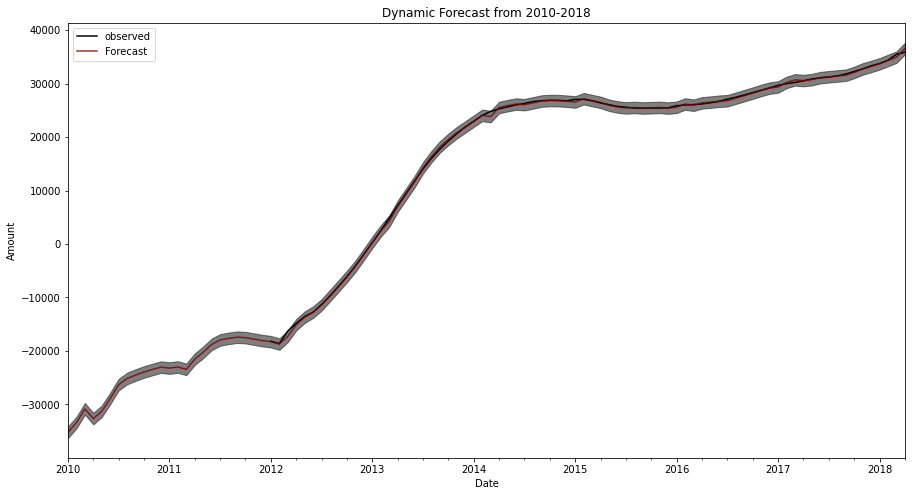

In [29]:
pred = sar_results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)

pred_ci = pred.conf_int() # this gives us the confidence interval for our forecasts

plt.figure(figsize = (15,8))
ax = data_diff['2012':].plot(label='observed',color='black')

pred.predicted_mean.plot(ax=ax, label='Forecast', color='maroon',alpha=0.8)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.5)

ax.set_title('Dynamic Forecast from 2010-2018')
ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()

In [44]:
# Model evaluation

y_ndynamic = pred.predicted_mean
y_actual = data_diff['2010-01-01':]

mean_absolute_percentage_error(y_actual, y_ndynamic)

0.012825766355036086

This means that forecasted results will be off by approximately 0.012% which is quite low and implies that our model perform very well. Researchers have often proved that the dynamic forecast can be a better choice so we will also explore it.

#### Dynamic Forecasting
The advancement in technolgy and the need for fast solutions has ehanced the application of dynamic forecasting in businesses today. Dynamic forecsating provides a faster and more accurate method of forecastig in a business setting. According to [Workday.com]('https://blog.workday.com/en-us/2021/dynamic-forecasting-a-north-star-for-businesses-in-uncertain-times.html'), dynamic forecasting relies on real-time data updated on arolling basis and it imporves the insights drawnf from such data. In this case, we use dynamic forecasting in our modeling to enhance the results we get from our data. 

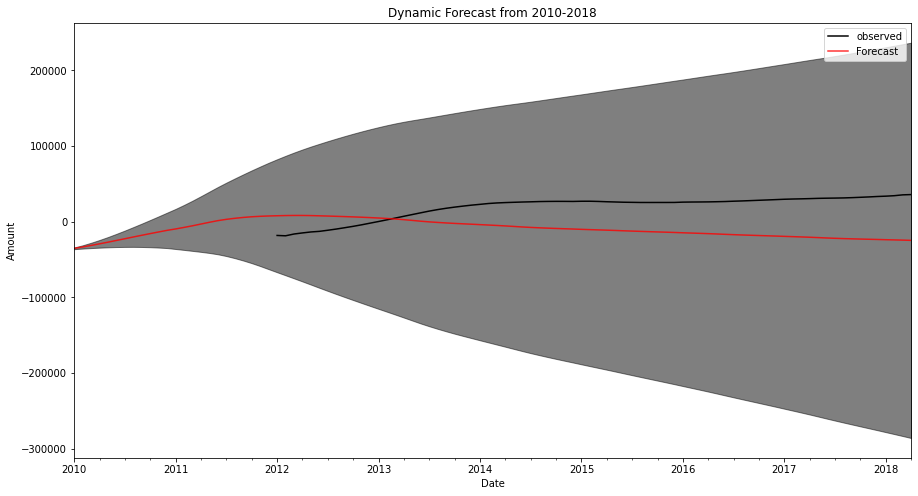

In [38]:
# Dynamic Forecasting

pred_dynamic = sar_results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=True)
pred_dynamic_ci = pred_dynamic.conf_int()

# Visualizing forecasted values

plt.figure(figsize = (15,8))
ax = data_diff['2012':].plot(label='observed',color='black')
pred_dynamic.predicted_mean.plot(ax=ax, label='Forecast', color='red',alpha=0.8)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.5)

ax.set_title('Dynamic Forecast from 2010-2018')
ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()


In [39]:
# Evaluation of the Dynamic Forecast
y_dynamic = pred_dynamic .predicted_mean
y_dactual = data_diff['2010-01-01':]
mean_absolute_percentage_error(y_dynamic, y_dactual)

4.242486761476446

The dynamic forecast has a higher mean absolute percentage error that is the values predicted for the future will be off by approximately 5%. Hence, non-dynamic forecast results is a better prediction of the future in this case.

#### Future Prediction

In [40]:
#predicting 5 years into the future

pred_fut = sar_results.get_forecast(steps= 72)

# Get confidence intervals of forecasts
pred_ci = pred_fut.conf_int()



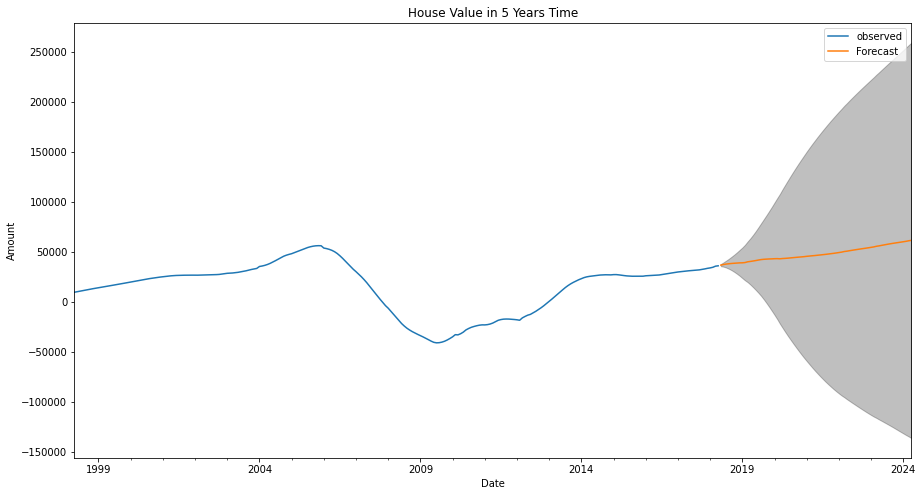

In [34]:
# Forecasting

ax =data_diff.plot(label='observed', figsize=(15, 8))
pred_fut .predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('House Value in 5 Years Time')
ax.set_xlabel('Date')
ax.set_ylabel('Amount')

plt.legend()
plt.show()

Our model predicts a slight increament which stagnates over the next five years.

In [35]:
# Long Term Investment

#prediction 20 years into the future

pred_fut_20 = sar_results.get_forecast(steps= 240)

# Get confidence intervals of forecasts
pred_ci = pred_fut_20.conf_int()


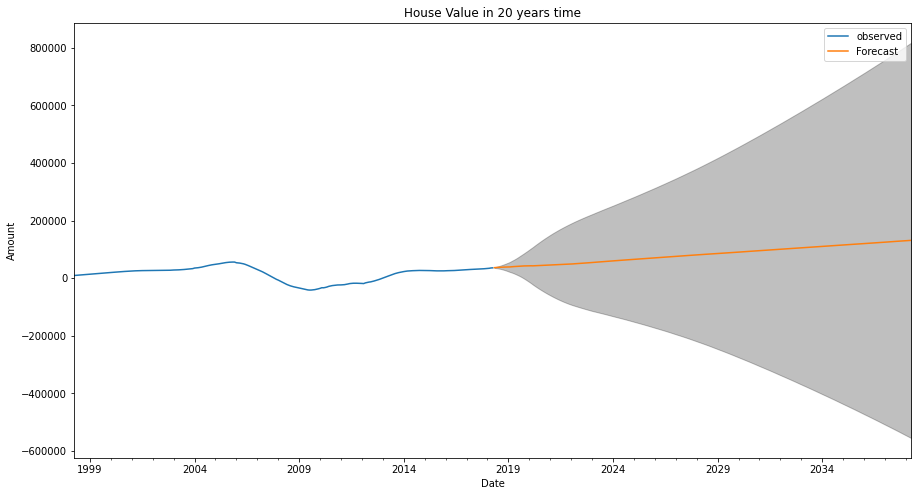

In [36]:
#Visualizing house values in 20 years
ax =data_diff.plot(label='observed', figsize=(15, 8))
pred_fut_20 .predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title('House Value in 20 years time')
ax.set_xlabel('Date')
ax.set_ylabel('Amount')

plt.legend()
plt.show()

Over the next 20 years the growth is still very minimal. This is in line with the Zillow homes forecast which expects that over the years there will be a considerable slow growth rate in the home value from the current 14.1% to 1.4% in the future. This is because the share of income spent on monthly mortgage payments has risen from 27.7% in February to 37.3% in October – well above a previous peak of 35% in 2006.
Housing payments are considered to be a financial burden when they exceed 30% of a household’s income.

# 6. Conclusion
* There are several discrepancies within the housing investment sector. Investors would rather invest in some cities than others, which is evident from the varying number of properties in the different cities.
* The top three cities with the highest median house prices are Atherton (California), Palm Beach(Florida), and Snowmass Village (Colorado).
* The cities with the highest ROI in 22 years are New York, Georgia state, New York, and Hawaii.
* The prices of houses also differ concerning the city ranks. Homes in highly-ranked cities have high median prices.
* Other factors, such as location also dictate changes in the price of house prices. For instance, houses in the coastal regions have higher median prices.
* Given that SARIMA is our best model, seasonality patterns are just as significant when projecting property values as past values.
* Using our model, we can also infer that the increase in home value would inevitably slow down significantly over the next few years.


# 7. Recommmendations
We advise the Horizon Real Estate Company;
* The company should focus on locations with great beaches and outdoor activities since houses in these locations fetch highest prices as this is seen from cities in California and Florida.
* Invest in the cities, New York and California, which has the highest Return On Investment. 
* Sell at a discounted price to increase sales over the next few years due to the slowing down of real estate price in the foreseeable future.